In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing_text import Preprocess
from sklearn.model_selection import train_test_split

from utils.util import create_folder


label_names = ['Algebra', 'Combinatorics', 'Geometry', ' Number Theory']
df = pd.read_csv("../data/classification/imo.csv")
df['post_canonical'] = df['post_rendered'].apply(Preprocess().fit)

def string_to_txt(path, file_name, string):
    if not file_name.endswith('.txt'):
        file_name += '.txt'
        
    file_path = f"{path}/{file_name}"

    with open(file_path, 'w') as file:
        file.write(string)

def plot_bar_chart(ax, labels, values, title, y_range=None):
    """
    Plot a bar chart on a specified axis with given labels and values, and annotate bars with values.

    Parameters:
        ax (matplotlib.axes.Axes): Axis object to draw the bar chart on.
        labels (list of str): Labels for each bar.
        values (list of numeric): Values corresponding to each label.
        title (str): Title of the bar chart.
        y_range (tuple of int, optional): Tuple (min, max) specifying the range of the y-axis.
    """
    bars = ax.bar(labels, values)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Label", fontsize=10)
    ax.set_ylabel("Data", fontsize=10)
    
    # Annotate bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.5, str(value),
                ha='center', va='top', fontsize=12, color='white', weight='bold')

    if y_range:
        ax.set_ylim(y_range[0], y_range[1])
    
    # Add a horizontal line for the highest value
    max_value = max(values)
    ax.axhline(y=max_value, color='red', linestyle='--', linewidth=1.5, label=f'Highest Value: {max_value}')

def prepare_dataset(df, reduce_algebra=None, reduce_combin=None, reduce_geomet=None, reduce_nt=None, truncate=False):
    shape_total = df.shape
    df = df[df['label'].notna()]
    shape_notna = df.shape
    
    print(f"Shape total: {shape_total}")
    print(f"Shape notna: {shape_notna}")
    
    algebra = df[df['label'] == 'Algebra'][['id_key', 'post_canonical', 'label']]
    combin = df[df['label'] == 'Combinatorics'][['id_key', 'post_canonical', 'label']]
    geomet = df[df['label'] == 'Geometry'][['id_key', 'post_canonical', 'label']]
    nt = df[df['label'] == 'Number Theory'][['id_key', 'post_canonical', 'label']]
    label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
    sum_label_values=sum(label_values)
    
    figure, axes = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")
    y_range = (0, 1450)
    
    plot_bar_chart(axes[0], label_names, label_values, f"DATASET DISTRIBUTION (BEFORE REDUCING={sum_label_values})", y_range=y_range)
    
    # Kalau mau disamain semua
    if truncate:
        m = min([algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]])
        algebra = algebra.sample(m, random_state=42)
        combin = combin.sample(m, random_state=42)
        geomet = geomet.sample(m, random_state=42)
        nt = nt.sample(m, random_state=42)
        label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
        sum_label_values=sum(label_values)

        plot_bar_chart(axes[1], label_names, label_values, f"DATASET DISTRIBUTION (AFTER REDUCING={sum_label_values}) USING THIS DATASET", y_range=y_range)
        
        
        return algebra, combin, geomet, nt
    
    if reduce_algebra is not None: algebra=algebra.sample(algebra.shape[0]-reduce_algebra, random_state=42)
    if reduce_combin is not None: combin=combin.sample(combin.shape[0]-reduce_combin, random_state=42)
    if reduce_geomet is not None: geomet=geomet.sample(geomet.shape[0]-reduce_geomet, random_state=42)
    if reduce_nt is not None: nt=nt.sample(nt.shape[0]-reduce_nt, random_state=42)
    label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
    sum_label_values=sum(label_values)
    
    plot_bar_chart(axes[1], label_names, label_values, f"DATASET DISTRIBUTION (AFTER REDUCING={sum_label_values}) USING THIS DATASET", y_range=y_range)

    return algebra, combin, geomet, nt


c:\wamp64\www\artofproblemsolving\models\utils\preprocessing_text.py:116: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, 'html.parser').get_text()
c:\wamp64\www\artofproblemsolving\models\utils\preprocessing_text.py:145: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


Shape total: (10968, 10)
Shape notna: (3845, 10)


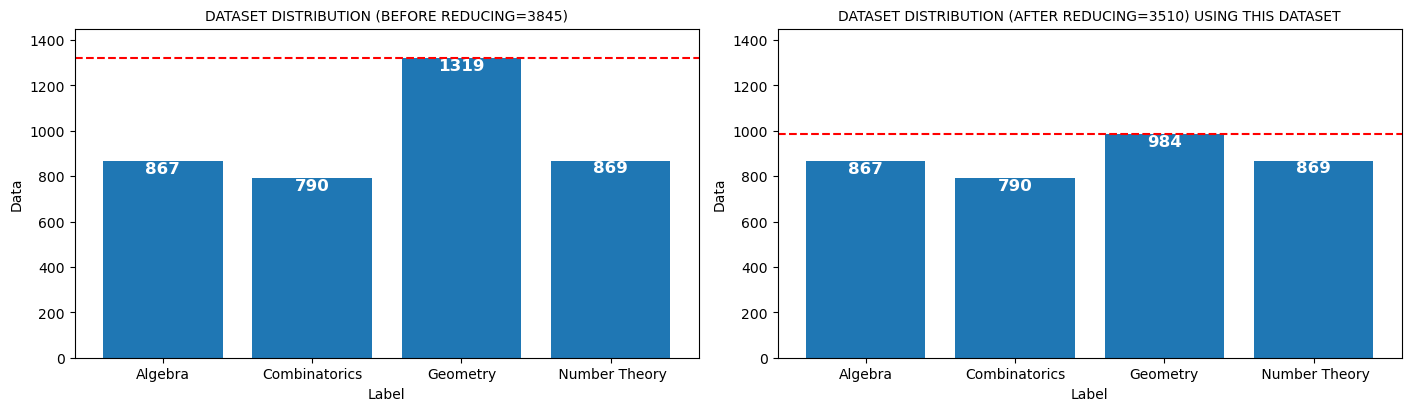

In [2]:
reduce_algebra = 0
reduce_combin = 0
reduce_geomet = 335
reduce_nt = 0
truncate = False

algebra, combin, geomet, nt = prepare_dataset(
    df, 
    reduce_algebra=reduce_algebra, 
    reduce_combin=reduce_combin, 
    reduce_geomet=reduce_geomet, 
    reduce_nt=reduce_nt,
    truncate=truncate)

algebra_combin_geomet_nt = [algebra, combin, geomet, nt]


Split train-test

In [3]:
test_size=0.2
random_state=42

train_path = "../data/classification/train"
test_path = "../data/classification/test"
create_folder(train_path)
create_folder(test_path)

all_train = []
all_test  = []
for each in algebra_combin_geomet_nt:
    train, test = train_test_split(each, test_size=test_size, random_state=random_state)
    all_train.append(train)
    all_test.append(test)
    
    current_label = str(list(each['label'])[0])
    current_path_train, current_path_test = f"{train_path}/{current_label}", f"{test_path}/{current_label}"
    create_folder(current_path_train)
    create_folder(current_path_test)
    
    train = train.to_dict('records')
    for i in range(len(train)):
        id_key = str(train[i]['id_key'])
        string = train[i]['post_canonical']
        string_to_txt(
            path=current_path_train, 
            file_name=id_key, 
            string=string
        )

    test = test.to_dict('records')
    for j in range(len(test)):
        id_key = str(test[j]['id_key'])
        string = test[j]['post_canonical']
        string_to_txt(
            path=current_path_test, 
            file_name=id_key, 
            string=string
        )

# For display distribution (below cell)
train_values = [
    all_train[0].shape[0],
    all_train[1].shape[0],
    all_train[2].shape[0],
    all_train[3].shape[0],
]

test_values = [
    all_test[0].shape[0],
    all_test[1].shape[0],
    all_test[2].shape[0],
    all_test[3].shape[0],
]


Folder --> '../data/classification/train' created
Folder --> '../data/classification/test' created
Folder --> '../data/classification/train/Algebra' created
Folder --> '../data/classification/test/Algebra' created
Folder --> '../data/classification/train/Combinatorics' created
Folder --> '../data/classification/test/Combinatorics' created
Folder --> '../data/classification/train/Geometry' created
Folder --> '../data/classification/test/Geometry' created
Folder --> '../data/classification/train/Number Theory' created
Folder --> '../data/classification/test/Number Theory' created


Total        = 3510
test_size    = 0.2
random_state = 42


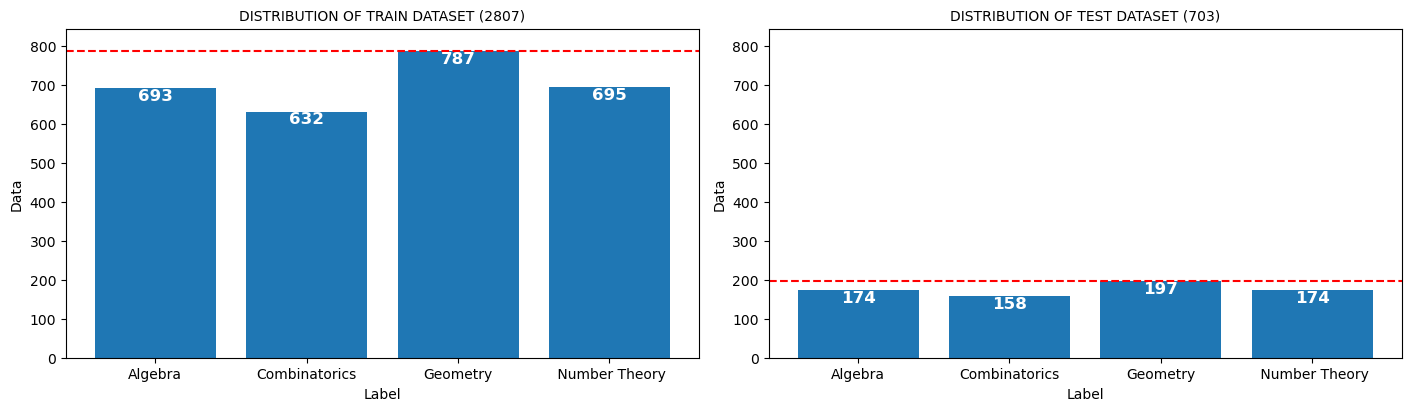

In [4]:
figure, ax = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")

plot_bar_chart(ax[0], label_names, train_values, f"DISTRIBUTION OF TRAIN DATASET ({sum(train_values)})",y_range=(0,845))
plot_bar_chart(ax[1], label_names, test_values, f"DISTRIBUTION OF TEST DATASET ({sum(test_values)})",y_range=(0,845))

print(f"Total        = {sum(train_values) + sum(test_values)}")
print(f"test_size    = {test_size}")
print(f"random_state = {random_state}")


In [2]:
# test_size=0.2
# algebra, combin, geomet, nt = split_by_label(df, reduce_geomet=300)

# temp1=[algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
# temp2=[round(temp1[0]*(1-test_size)), round(temp1[1]*(1-test_size)), round(temp1[2]*(1-test_size)), round(temp1[3]*(1-test_size))]
# temp3=[round(temp1[0]*test_size), round(temp1[1]*test_size), round(temp1[2]*test_size), round(temp1[3]*test_size)]
# print(f"               {'n':>7s} {'train':>7s} {'test':>7s}")
# print(f"Algebra       :{str(temp1[0]):>7s} {str(temp2[0]):>7s} {str(temp3[0]):>7s}")
# print(f"Combinatorics :{str(temp1[1]):>7s} {str(temp2[1]):>7s} {str(temp3[1]):>7s}")
# print(f"Geometry      :{str(temp1[2]):>7s} {str(temp2[2]):>7s} {str(temp3[2]):>7s}")
# print(f"NT            :{str(temp1[3]):>7s} {str(temp2[3]):>7s} {str(temp3[3]):>7s}")
# print("_________________________________________+")
# print(f"Total         :{str(sum(temp1)):>7s} {str(sum(temp2)):>7s} {str(sum(temp3)):>7s}")


                     n   train    test
Algebra       :    815     652     163
Combinatorics :    737     590     147
Geometry      :    972     778     194
NT            :    795     636     159
_________________________________________+
Total         :   3319    2656     663
